# Imports

In [1]:
import argparse, os, pickle, random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 447
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Random Seed:  447
Device: cpu


In [3]:
!pwd

/Users/emrecanacikgoz/Desktop/Comp447/Deep_Unsupervised_Learning_Class_Materials/PS6


# Configurations

In [4]:
# Root directory for dataset
#dataroot = "/home/emrecan/Datasets/"
dataroot = "/Users/emrecanacikgoz/Desktop/Comp447/data/"

num_epochs = 5
batch_size = 128
image_size = 64
lr = 5e-5

# Size of z latent vector (i.e. size of generator input)
dim_z = 100

CRITIC_ITERATIONS = 5
WEIGHT_CLIP = 0.01

# Dataloader

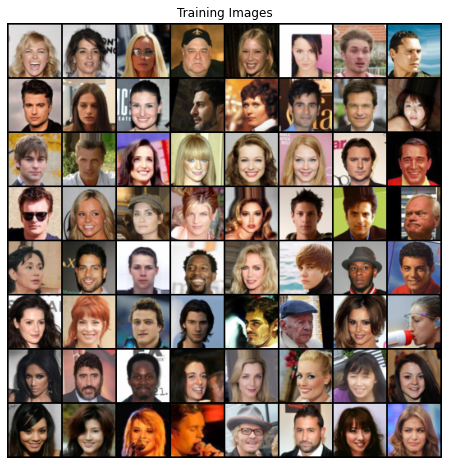

In [5]:
# Create the dataset
trans = transforms.Compose([transforms.Resize(image_size),
                            transforms.CenterCrop(image_size),
                            transforms.ToTensor(),
                            ])
dataset = datasets.ImageFolder(root=dataroot, transform=trans)
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)


# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))


# Model

In [6]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [7]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, dim_z):
        super(Generator, self).__init__()
        self.up_scale1  = nn.ConvTranspose2d(in_channels=dim_z, out_channels=512, kernel_size=4, stride=1, padding=0)
        self.up_scale2  = nn.ConvTranspose2d(in_channels=512,   out_channels=256, kernel_size=4, stride=2, padding=1)
        self.up_scale3  = nn.ConvTranspose2d(in_channels=256,   out_channels=128, kernel_size=4, stride=2, padding=1)
        self.up_scale4  = nn.ConvTranspose2d(in_channels=128,   out_channels=64,  kernel_size=4, stride=2, padding=1)
        self.up_scale5  = nn.ConvTranspose2d(in_channels=64,    out_channels=3,   kernel_size=4, stride=2, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(512)
        self.batchnorm2 = nn.BatchNorm2d(256)
        self.batchnorm3 = nn.BatchNorm2d(128)
        self.batchnorm4 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(True)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.up_scale1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.up_scale2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        
        x = self.up_scale3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        
        x = self.up_scale4(x)
        x = self.batchnorm4(x)
        x = self.relu(x)
        
        x = self.up_scale5(x)
        out = self.tanh(x)
        return out

In [8]:
# Create the generator
netG = Generator(dim_z).to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (up_scale1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
  (up_scale2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (up_scale3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (up_scale4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (up_scale5): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batchnorm1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (tanh): Tanh()
)


In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.down_scale1 = nn.Conv2d(in_channels=3,   out_channels=64,  kernel_size=4, stride=2, padding=1)
        self.down_scale2 = nn.Conv2d(in_channels=64,  out_channels=128, kernel_size=4, stride=2, padding=1)
        self.down_scale3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1)
        self.down_scale4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1)
        self.down_scale5 = nn.Conv2d(in_channels=512, out_channels=1,   kernel_size=4, stride=1, padding=0)

        self.batchnorm2 = nn.BatchNorm2d(128)
        self.batchnorm3 = nn.BatchNorm2d(256)
        self.batchnorm4 = nn.BatchNorm2d(512)
        self.leaky_relu = nn.LeakyReLU(0.2, inplace=True)

        
    def forward(self, x):
        
        x = self.down_scale1(x)
        x = self.leaky_relu(x)
        
        x = self.down_scale2(x)
        x = self.batchnorm2(x)
        x = self.leaky_relu(x)
        
        x = self.down_scale3(x)
        x = self.batchnorm3(x)
        x = self.leaky_relu(x)
        
        x = self.down_scale4(x)
        x = self.batchnorm4(x)
        x = self.leaky_relu(x)
        
        out = self.down_scale5(x)
        return out

In [13]:
# Create the Discriminator
critic = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
critic.apply(weights_init)

# Print the model
print(critic)

Discriminator(
  (down_scale1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (down_scale2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (down_scale3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (down_scale4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (down_scale5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
  (batchnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leaky_relu): LeakyReLU(negative_slope=0.2, inplace=True)
)


# Loss Functions and Optimizers

In [15]:
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, dim_z, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Optimizers for both G and D
optimizer_critic = optim.RMSprop(critic.parameters(), lr=lr)
optimizerG = optim.RMSprop(netG.parameters(), lr=lr)

# Training

In [16]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, (data, _) in enumerate(dataloader, 0):
        data = data.to(device)
        cur_batch_size = data.shape[0]
        
        # Train Critic: max E[critic(real)] - E[critic(fake)]
        for _ in range(CRITIC_ITERATIONS):
            
            critic.zero_grad()
            
            fake = netG(fixed_noise)
            critic_real = critic(data).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake))
            
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            optimizer_critic.step()

            # clip critic weights between -0.01, 0.01
            for p in critic.parameters():
                p.data.clamp_(-WEIGHT_CLIP, WEIGHT_CLIP)
                
        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        gen_fake = critic(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        netG.zero_grad()
        loss_gen.backward()
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}]\tLoss_D: {loss_critic:.4f}\tLoss_G: {loss_gen:.4f}')

        # Save Losses for plotting later
        G_losses.append(loss_gen.item())
        D_losses.append(loss_critic.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/1583]	Loss_D: -0.0355	Loss_G: 0.0069


KeyboardInterrupt: 

# Results

In [ ]:
#with open("./IMGS_W", "wb") as fp:   #Pickling
#    pickle.dump(img_list, fp)
#with open("./DLOSS_W", "wb") as fp:   #Pickling
#    pickle.dump(D_losses, fp)
#with open("./GLOSS_W", "wb") as fp:   #Pickling
#    pickle.dump(G_losses, fp)


In [11]:
with open("./IMGS_W", "rb") as fp:   # Unpickling
    IMGSLIST = pickle.load(fp)

with open("./GLOSS_W", "rb") as fp:   # Unpickling
    GLOSS = pickle.load(fp)
    
with open("./DLOSS_W", "rb") as fp:   # Unpickling
    DLOSS = pickle.load(fp)


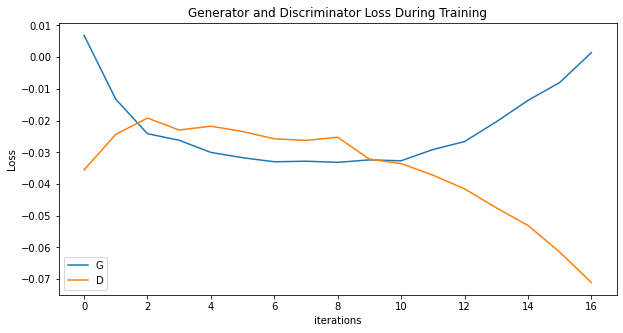

In [19]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Visualization of Generator Outputs

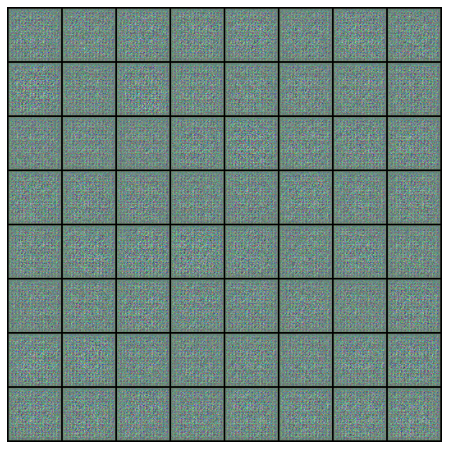

In [22]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

### Real Images vs. Fake Images

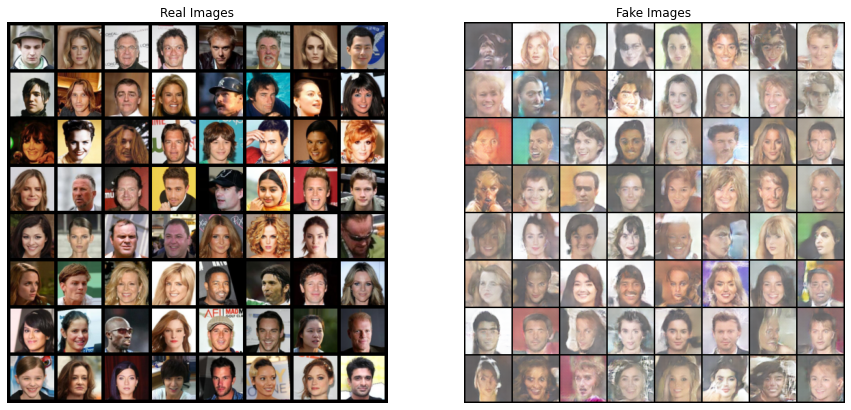

In [14]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(IMGSLIST[-1],(1,2,0)))
plt.show()